In [329]:
from sys import maxsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from IPython.display import display, HTML

from regression import *
from regression import _convertOrdinalVariable

%matplotlib inline

# Stochastic Gradient Descent

In [330]:
def SGD(x, y, learningRate, error):
    x = np.array(x)
    y = np.array(y)

    # Reshape 1-D arrays to column format
    # if len(x.shape) == 1:
    #     x = x.reshape(-1, 1)

    N = len(x)
    currentError = maxsize
    lastError = 0
    beta = np.zeros(x.shape[1])

    while currentError > error:
        yPredicted = x.dot(beta)
        sqErrGradient = np.array(np.dot(x.T, (yPredicted - y)) / N)
        beta -= learningRate * sqErrGradient
        currentError = np.sum(np.square(y - yPredicted)) / N

        if abs(lastError - currentError) < error:
            break
        lastError = currentError

    return beta

In [331]:
"""
inputVals: vector in form of [x1, x2, ..., xn]
beta: vector of beta coefficients in form [b0, b1, b2, ..., bn]
"""
def linRegEstimate(inputVals, beta, insertOnes=True):
    x = np.array(inputVals)
    
    if insertOnes:
        print('Inserting one for intercept')
        inputMatrix = np.insert(x, 0, 1)
        print(inputMatrix)
    else:
        inputMatrix = np.array(x)
        
    return np.sum(inputMatrix.dot(beta))


def computeR2(x, y, beta, insertOnes=True):
    # Reshape 1-D arrays to column format
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
        
    yMean = np.mean(y)
#     print('Y:', y)
#     print('X:', x)
#     print('Y mean:', yMean)
    yPredicted = np.array([linRegEstimate(xVal, beta, insertOnes) for xVal in x])
#     print('Y predicted:', yPredicted)
    ssTotal = np.sum(np.square(y - yMean))
    ssRegression = np.sum(np.square(yPredicted - yMean))
#     print('SSTotal:', ssTotal)
#     print('Residuals:', np.sum(np.square(y - yPredicted)))
#     print('SSRegression:', np.sum(np.square(yPredicted - yMean)))
    ssError = np.sum(np.square(y - yPredicted))
#     print('SST={}, SSR={}, SSE={}'.format(ssTotal, ssRegression, ssError))
    
    return 1 - ssError / ssRegression

# Air Quality UCI Set
### Source: UCI ML Repository https://archive.ics.uci.edu/ml/datasets/Air+Quality

In [332]:
convertEuropeanFloats = lambda val: float(val.replace(',', '.'))
airQualityDf = pd.read_csv('data/AirQualityUCI.csv', sep=';',
                           converters={
        'CO(GT)': convertEuropeanFloats,
        'C6H6(GT)': convertEuropeanFloats,
        'T': convertEuropeanFloats,
        'RH': convertEuropeanFloats
    })
airQualityDf.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

columnNamesByType = getDfNamesByType(airQualityDf)
airQualityXColNames = [col for col in list(columnNamesByType['float64']) + list(columnNamesByType['int64'])
                      if col != 'CO(GT)']
airQualityDf.drop(airQualityDf[airQualityDf['CO(GT)'] == -200.0].index, inplace=True)

for xCol in airQualityXColNames:
    # -200 means missing value
    airQualityDf.drop(airQualityDf[airQualityDf[xCol] == -200.0].index, inplace=True)

In [333]:
airQualityY = airQualityDf['CO(GT)']
airQualityXCols = [airQualityDf[attr]
                   for attr in airQualityXColNames]

COValues = airQualityY.as_matrix()

## Predicting CO Concentration from C6H6 (Benzene) Concentration
### Benzene is a highly flammable core component of gasoline

Single regression beta: [ 0.01635742  0.20595568]
Inserting one for intercept
[  1.   11.9]
Inserting one for intercept
[ 1.   9.4]
Inserting one for intercept
[ 1.  9.]
Inserting one for intercept
[ 1.   9.2]
Inserting one for intercept
[ 1.   6.5]
Inserting one for intercept
[ 1.   4.7]
Inserting one for intercept
[ 1.   3.6]
Inserting one for intercept
[ 1.   3.3]
Inserting one for intercept
[ 1.   2.3]
Inserting one for intercept
[ 1.   1.1]
Inserting one for intercept
[ 1.   1.6]
Inserting one for intercept
[ 1.   3.2]
Inserting one for intercept
[ 1.  8.]
Inserting one for intercept
[ 1.   9.5]
Inserting one for intercept
[ 1.   6.3]
Inserting one for intercept
[ 1.  5.]
Inserting one for intercept
[ 1.   5.2]
Inserting one for intercept
[ 1.   7.3]
Inserting one for intercept
[  1.   11.5]
Inserting one for intercept
[ 1.   8.8]
Inserting one for intercept
[ 1.   8.3]
Inserting one for intercept
[  1.   11.2]
Inserting one for intercept
[  1.   20.8]
Inserting one for intercept


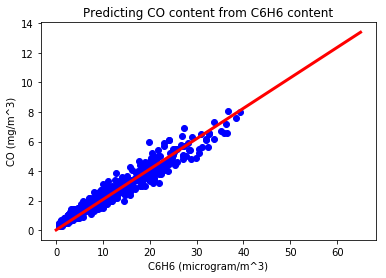

In [334]:
c6h6GTValues = airQualityDf['C6H6(GT)'].as_matrix()
c6h6GTX = np.insert(c6h6GTValues.reshape(-1, 1), 0, np.ones(len(c6h6GTValues)), axis=1)
c6h6VsCOBetas = SGD(c6h6GTX, COValues, 0.001, 0.0001)
print('Single regression beta:', c6h6VsCOBetas)
print('R^2:', computeR2(c6h6GTValues, COValues, c6h6VsCOBetas))
xRange = np.arange(0, 70, 5)
predictedLine = [linRegEstimate([c6h6], c6h6VsCOBetas) for c6h6 in xRange]

plt.plot(c6h6GTValues, COValues, 'bo', xRange, predictedLine, 'r-', linewidth=3.0)
plt.title('Predicting CO content from C6H6 content')
plt.xlabel('C6H6 (microgram/m^3)')
plt.ylabel('CO (mg/m^3)')

# Bivariate Case
## Predicting CO Levels from Benzene and Titania (PT08.S2) Levels

Benzene-PT08 Beta: [  1.45717947e-06   5.06089092e-05   2.61641133e-03]
[   0.5  448. ]
Inserting one for intercept
[   1.     0.5  448. ]
Inserting one for intercept
[   1.      4.37  578.6 ]
Inserting one for intercept
[   1.      8.24  709.2 ]
Inserting one for intercept
[   1.     12.11  839.8 ]
Inserting one for intercept
[   1.     15.98  970.4 ]
Inserting one for intercept
[  1.00000000e+00   1.98500000e+01   1.10100000e+03]
Inserting one for intercept
[  1.00000000e+00   2.37200000e+01   1.23160000e+03]
Inserting one for intercept
[  1.00000000e+00   2.75900000e+01   1.36220000e+03]
Inserting one for intercept
[  1.00000000e+00   3.14600000e+01   1.49280000e+03]
Inserting one for intercept
[  1.00000000e+00   3.53300000e+01   1.62340000e+03]
Inserting one for intercept
[  1.00000000e+00   1.19000000e+01   1.04600000e+03]
Inserting one for intercept
[   1.     9.4  955. ]
Inserting one for intercept
[   1.    9.  939.]
Inserting one for intercept
[   1.     9.2  948. ]
Inserting

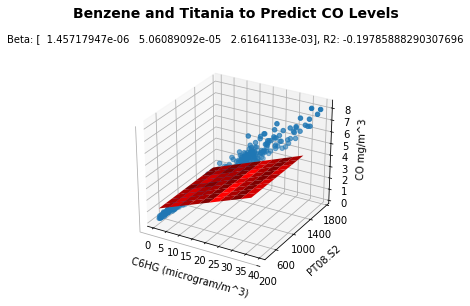

In [335]:
benzenePT08Df = airQualityDf[['C6H6(GT)', 'PT08.S2(NMHC)']]
benzenePT08 = benzenePT08Df.as_matrix()
benzenePT08X = np.insert(benzenePT08, 0, np.ones(len(benzenePT08)), axis=1)
benzenePT08Betas = SGD(benzenePT08X, COValues, 0.0000001, 0.00001)
print('Benzene-PT08 Beta:', benzenePT08Betas)

benzeneMin = benzenePT08[:, 0].min()
benzeneMax = benzenePT08[:, 0].max()
PT08Min = benzenePT08[:, 1].min()
PT08Max = benzenePT08[:, 1].max()

benzeneDomain = np.arange(benzeneMin, benzeneMax, (benzeneMax - benzeneMin) / 10)
PT08Domain = np.arange(PT08Min, PT08Max, (PT08Max - PT08Min) / 10)
benzenePT08Domains = np.array([benzeneDomain, PT08Domain]).T
# benzenePT08Domains = np.insert(benzenePT08Domains,
#                                   0, np.ones(len(benzenePT08Domains)), axis=1)
print(benzenePT08Domains[0])
benzenePT08PredictedCO = [linRegEstimate(xy, benzenePT08Betas)
                          for xy in benzenePT08Domains]

fig = plt.figure()
fig.suptitle('Benzene and Titania to Predict CO Levels',
             y=1.05, fontsize=14, fontweight='bold')

benzPT08Plot = fig.add_subplot(111, projection='3d')
benzPT08Plot.scatter(benzenePT08[:, 0], benzenePT08[:, 1], COValues)
gridBenzPTO8, gridPT08Domain = np.meshgrid(benzeneDomain, PT08Domain)
benzPT08Plot.plot_surface(gridBenzPTO8, gridPT08Domain, benzenePT08PredictedCO, color='r')
benzPT08Plot.set_title('Beta: {}, R2: {}'.format(benzenePT08Betas,
                                                 computeR2(benzenePT08, COValues, benzenePT08Betas)),
                       y=1.05, fontsize=10)
benzPT08Plot.set_xlabel('C6HG (microgram/m^3)', labelpad=10.5)
benzPT08Plot.set_ylabel('PT08.S2', labelpad=10.5)
benzPT08Plot.set_zlabel('CO mg/m^3')

benzPT08Plot.set_yticks(np.arange(200, 2000, 400))
benzPT08Plot.dist = 12

plt.tight_layout()

# Multivariate Linear Regression

In [336]:
airQualityMultiCols = list(set(airQualityXColNames) - set(['T', 'RH',' PT08.S4(NOx)',
                                                           'PT08.S4(NO2)', 'NMHC(GT)',
                                                          'PT08.S3(NOx)', 'PT08.S5(O3)']))
display(airQualityDf[airQualityMultiCols].head())

multiAirQualityXVals = airQualityDf[airQualityMultiCols].as_matrix()
print(multiAirQualityXVals)

multiAirQualityBeta = SGD(multiAirQualityXVals, COValues, 0.0000001, 0.000001)
print('Beta:', multiAirQualityBeta)
computedAirQualityR2 = computeR2(multiAirQualityXVals,
                                COValues, multiAirQualityBeta, False)
betaAttributeMap = {attr: beta for attr, beta in zip(['Intercept'] + airQualityMultiCols, multiAirQualityBeta)}

# print('Betas for all X Cols:', multiAirQualityBeta)
print('R2 for all X cols:', computedAirQualityR2)
display(pd.DataFrame(betaAttributeMap, index=np.arange(1)))

,PT08.S2(NMHC),NO2(GT),NOx(GT),C6H6(GT),PT08.S1(CO)
0,1046,113,166,11.9,1360
1,955,92,103,9.4,1292
2,939,114,131,9.0,1402
3,948,122,172,9.2,1376
4,836,116,131,6.5,1272


[[ 1046.    113.    166.     11.9  1360. ]
 [  955.     92.    103.      9.4  1292. ]
 [  939.    114.    131.      9.   1402. ]
 ..., 
 [ 1136.    102.    174.     14.6  1371. ]
 [ 1107.    108.    167.     13.7  1406. ]
 [ 1155.    110.    185.     15.2  1425. ]]
Beta: [ 0.00274752  0.00057974  0.01131175  0.00145753 -0.00162983]
R2 for all X cols: 0.909015371522


,C6H6(GT),Intercept,NO2(GT),NOx(GT),PT08.S2(NMHC)
0,-0.00163,0.002748,0.011312,0.001458,0.00058


# Multivariate Linear Regression with Categorical Attributes
## HR Employee Dataset
### Source: Kaggle https://www.kaggle.com/ludobenistant/hr-analytics

In [337]:
hrDf = pd.read_csv('data/HR_comma_sep.csv', sep=',')
# hrDf.loc[hrDf['last_evaluation'], 'last_evaluation'] = 
hrDf['last_evaluation'] *= 100
hrDf['satisfaction_level'] *= 100
display(hrDf.head())


# convertedHrDf = _convertOrdinalVariable(hrDf, 'salary', ['low', 'medium', 'high'])
convertedHrDf = convertNominalVariables(hrDf, ['sales', 'salary'])
display(convertedHrDf.head())
# print(convertedHrDf['sales'].unique())

hrYColName = 'satisfaction_level'
hrCategoricalCols = ['sales', 'salary']
hrXColNames = ['number_project', 'last_evaluation', 'time_spend_company',
              'promotion_last_5years', 'satisfaction_level']
for col in hrCategoricalCols:
    hrXColNames.extend(categoricalColumnNames(col, convertedHrDf[col].unique()))
print(hrXColNames)

# display(convertedHrDf[hrXColNames].head())
hrXMatrix = convertedHrDf[hrXColNames].as_matrix()
hrYMatrix = convertedHrDf[hrYColName].as_matrix()
# print(hrXMatrix.shape)
# print(hrYMatrix.reshape(-1, 1).shape)

beta = np.linalg.lstsq(hrXMatrix, hrYMatrix)[0] 
# print(computeR2(hrXMatrix, hrYMatrix, beta))

hrBeta = SGD(hrXMatrix, hrYMatrix, 0.000001, 0.01)
hrR2 = computeR2(hrXMatrix, hrYMatrix, hrBeta, False)
print('Beta:', hrBeta)
print('R^2:', hrR2)
displayBetaTable(hrXColNames, hrBeta)

# plotSingleVarRegressions([convertedHrDf[col] for col in hrXColNames], convertedHrDf[hrYColName])

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,38.0,53.0,2,157,3,0,1,0,sales,low
1,80.0,86.0,5,262,6,0,1,0,sales,medium
2,11.0,88.0,7,272,4,0,1,0,sales,medium
3,72.0,87.0,5,223,5,0,1,0,sales,low
4,37.0,52.0,2,159,3,0,1,0,sales,low


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,sales_technical,sales_support,sales_management,sales_IT,sales_product_mng,sales_marketing,sales_RandD,salary_low,salary_medium,salary_high
0,38.0,53.0,2,157,3,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,80.0,86.0,5,262,6,0,1,0,sales,medium,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11.0,88.0,7,272,4,0,1,0,sales,medium,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,72.0,87.0,5,223,5,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,37.0,52.0,2,159,3,0,1,0,sales,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


['number_project', 'last_evaluation', 'time_spend_company', 'promotion_last_5years', 'satisfaction_level', 'sales_sales', 'sales_accounting', 'sales_hr', 'sales_technical', 'sales_support', 'sales_management', 'sales_IT', 'sales_product_mng', 'sales_marketing', 'sales_RandD', 'salary_low', 'salary_medium', 'salary_high']
Beta: [  5.39201202e-03   1.07503180e-01   8.24003990e-03   2.05497072e-04
   8.78239507e-01   1.37627886e-03   4.63547748e-05   1.68755773e-04
   6.06186844e-04   6.35604884e-04   1.88294123e-04   3.91396916e-04
   3.07703891e-04   2.81078588e-04   2.81275838e-04   1.43062427e-03
   2.20310233e-03   6.49203894e-04]
R^2: 0.976482285314


,Intercept,last_evaluation,number_project,promotion_last_5years,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,satisfaction_level,time_spend_company
0,0.005392,0.00824,0.107503,0.87824,0.002203,0.000649,0.000308,0.001431,0.000169,0.000606,0.000391,0.000281,0.000281,0.000046,0.000188,0.000636,0.001376,0.000205


# Multivariate Linear Regression with Categorical Attributes
### Source: UCI ML Repository https://archive.ics.uci.edu/ml/datasets/Automobile

In [338]:
carDf = pd.read_csv('data/imports-85.csv', sep=',')
carYColName = 'Price'
categoricalCarCols = ['Make', 'FuelType', 'DriveWheels']
carXColNames = ['CityMPG', 'HighwayMPG'] + categoricalCarCols


carDf.drop(carDf[carDf['Horsepower'] == '?'].index, inplace=True)
carDf.drop(carDf[carDf['Price'] == '?'].index, inplace=True)
carDf['Horsepower'] = pd.to_numeric(carDf['Horsepower'])
carDf['Price'] = pd.to_numeric(carDf['Price'])

carColNamesByType = getDfNamesByType(carDf)
makeXCols = categoricalColumnNames('Make', carDf['Make'].unique())
numberCylindersXCols = categoricalColumnNames('NumberCylinders',
                                              carDf['NumberCylinders'].unique())
# carXColNames = ['CityMPG', 'HighwayMPG'] + makeXCols
# carXColNames = ['Price'] + makeXCols
display(carDf[carXColNames + [carYColName]].head())

nominalCarDf = convertNominalVariables(carDf, ['Make', 'FuelType', 'DriveWheels'])
convertedCarDf = _convertOrdinalVariable(nominalCarDf, 'NumberCylinders',
                                         ['two', 'three', 'four', 'five', 'six', 'eight', 'twelve'])
convertedCarXColNames = ['CityMPG', 'HighwayMPG']
for col in categoricalCarCols:
    convertedCarXColNames.extend(categoricalColumnNames(col, convertedCarDf[col].unique()))

for col in makeXCols + numberCylindersXCols:
    convertedCarDf[col] = convertedCarDf[col].astype('int')

,CityMPG,HighwayMPG,Make,FuelType,DriveWheels,Price
0,21,27,alfa-romero,gas,rwd,13495
1,21,27,alfa-romero,gas,rwd,16500
2,19,26,alfa-romero,gas,rwd,16500
3,24,30,audi,gas,fwd,13950
4,18,22,audi,gas,4wd,17450


## Predicting Price from Make, Number of Cylinders, City MPG, and Highway MPG

In [339]:
carXColsDf = convertedCarDf[convertedCarXColNames]
carXColMatrix = carXColsDf.as_matrix()
carYColMatrix = convertedCarDf[carYColName].as_matrix()

carBeta = SGD(carXColMatrix, carYColMatrix, 0.0001, 0.1)
print('Beta shape:', carBeta.shape)
print('X Shape:', carXColMatrix.shape)
carCorrelation = computeR2(carXColMatrix, carYColMatrix, carBeta, False)
print('Car price prediction')
print('Beta:', carBeta)
displayBetaTable(carXColNames, carBeta)
print('R^2:', carCorrelation)

Beta shape: (28,)
X Shape: (199, 28)
Car price prediction
Beta: [  -312.32470374   -123.18627133  -1187.48173963   3645.12435204
   9245.10865086    484.21926057  -2778.18904217  -1570.44285973
  -6060.75395815  15007.98097189  -2164.88032061  14683.57537331
   -746.96488452  -2726.96341133  -1255.25102886  -1479.84611687
  -3004.59791147  13678.08409211   1456.90621761  -2653.67871541
  -2332.90940801  -1214.97892582   1590.22698384  13906.95460318
  16707.33297645  12059.59382332   9710.10766184   8844.58609447]


,CityMPG,DriveWheels,FuelType,HighwayMPG,Intercept,Make
0,-123.186271,484.219261,9245.108651,-1187.48174,-312.324704,3645.124352


R^2: 0.864456702967
